**Piotr Duszak - praca domowa 2 - wykorzystanie metody SHAP na przykładzie wyznaczania ceny domów**

W niniejszym notebooku będzie testowana metoda SHAP do sprawdzenia, jak duży wpływ ma dana zmienna na predykcję modelu. Wykorzystano dane dotyczące nieruchomości (na wejściu są informacje takie jak liczba sypialni, liczba łazienek, metraż, współrzędne geograficzne, itp., a model ma przewidzieć jego cenę).

Wykorzystano dwa modele. Jeden z nich to random forest (przy użyciu biblioteki xgboost), a drugi to maszyna wektorów nośnych (przy użyciu biblioteki sklearn).

# Wczytywanie danych

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
# Wczytanie danych
hous_data = pd.read_csv('drive/MyDrive/kc_house_data.csv')
# Zamiana daty ze stringa na datę
hous_data['date'] = hous_data['date'].apply(lambda x: datetime.strptime(x, '%Y%m%dT%H%M%S').date())
hous_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Dane składają się z 21613 rekordów. W każdym są następujące informacje: 
* Id: unikalny identyfikator każdego sprzedanego domu
* Date: data sprzedaży domu
* Price: cena każdego sprzedanego domu
* Bedrooms: liczba sypialni
* Bathrooms: liczba łazienek, gdzie 0,5 odpowiada pokojowi z toaletą, ale bez prysznica
* Sqft_living: powierzchnia wnętrza mieszkania
* Sqft_lot: powierzchnia działki
* Floors: liczba pięter
* Waterfront: zmienna określająca, czy mieszkanie wychodziło na nabrzeże, czy nie
* View: indeks od 0 do 4 pokazujący, jak dobry był widok z nieruchomości
* Condition: indeks od 1 do 5 na temat stanu mieszkania
* Grade: indeks od 1 do 13, oceniający jakość wykonania
* Sqft_above: powierzchnia wnętrza mieszkania, znajdującej się nad poziomem gruntu
* Sqft_basement: powierzchnia wnętrza mieszkania, znajdującej się poniżej poziomu gruntu
* Yr_built: rok, w którym dom został pierwotnie zbudowany
* Yr_renovated: rok ostatniego remontu domu
* Zipcode: kod pocztowy
* Lat: szerokość geograficzna
* Long: długość geograficzna
* Sqft_living15: powierzchnia mieszkania najbliższych 15 sąsiadów
* Sqft_lot15: powierzchnia działki 15 najbliższych sąsiadów

Z bazy danych postanowiono usunąć id i zipcode, gdyż wydaje się, że nie powinny mieć wpływu na cenę mieszkania. Datę sprzedaży rozdzielono na trzy wartości (rok, miesiąc i dzień). Poniżej zmodyfikowana baza danych z podstawowymi statystykami.

In [2]:
hous_data['year'] = hous_data['date'].apply(lambda x: x.year)
hous_data['month'] = hous_data['date'].apply(lambda x: x.month)
hous_data['day'] = hous_data['date'].apply(lambda x: x.day)
hous_data.drop(['id', 'zipcode', 'date'], axis=1, inplace=True)
hous_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652,2014.322954,6.574423,15.688197
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631,0.467616,3.115308,8.635063
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000,2014.000000,6.000000,16.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,9.000000,23.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000


In [3]:
# Przekonwertowanie wszystkich liczb na float, pomieszanie wierszy i rozdzielenie na zbriór uczący, testowy i walidacyjny
length = hous_data.shape[0]
hous_data = hous_data.astype(float)
hous_data = hous_data.sample(frac=1, random_state=3).reset_index(drop=True)
train, val, test = hous_data.loc[:int(length*0.5)], hous_data.loc[int(length*0.5):int(length*0.75)], hous_data.loc[int(length*0.75):]
train_y, train_x = train['price'], train[train.columns[1:]]
val_y, val_x = val['price'], val[train.columns[1:]]
test_y, test_x = test['price'], test[train.columns[1:]]

Dane zostały podzielone na dane treningowe, walidacyjne oraz testowe (każdy zestaw na wejście oraz wyjście).

# 1. Nauczenie modelu przy pomocy gradient boostingu


In [4]:
from xgboost import XGBRegressor
from xgboost import plot_tree
# Stworzenie i wytrenowanie modelu
tree_regressor = XGBRegressor(criterion='mse', max_depth=10, objective='reg:squarederror')
tree_regressor.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, criterion='mse', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Został nauczony model decyzyjny (o maksymalnej głębokości 15), a następnie zewaluowany na danych treningowych, walidacyjnych i testowych.

In [5]:
tree_train_r2 = tree_regressor.score(train_x, train_y)
tree_val_r2 = tree_regressor.score(val_x, val_y)
tree_test_r2 = tree_regressor.score(test_x, test_y)
print('Współczynnik determinacji dla zbiory treningowego {}'.format(tree_train_r2))
print('Współczynnik determinacji dla zbiory walidacyjnego {}'.format(tree_val_r2))
print('Współczynnik determinacji dla zbiory testowego {}'.format(tree_test_r2))

Współczynnik determinacji dla zbiory treningowego 0.992043742467373
Współczynnik determinacji dla zbiory walidacyjnego 0.8751400930847416
Współczynnik determinacji dla zbiory testowego 0.8797340504829191


Dla modelu wyznaczono współczynniki determinacji (dla zbioru uczącego, walidacyjnego i treningowego), który określa jak dobrze model jest dopasowany do danych (maksymalna wartość to 1).

Jak widać po tych współczynnikach model nie jest idealny, ale powinien całkiem dobrze szacować wartość nieruchomości.

# 2. Wyznaczeni predykcji dla trzech obserwacji

In [6]:
# Wyznaczenie predykcji dla trzech elementów ze zbioru treningowego (jako, że zbiór ten był tasowany mogą to być równie dobrze 3 pierwsze).
# Przy badaniu wpływu danego parametru na predykcję modelu nie ma też szczególnie znaczenia, czy to zbiór uczący, czy testowy
observations = train_x[:3]
predictions_tree = tree_regressor.predict(observations)
observations_show = observations.append(train_x.describe().loc['mean'])
observations_show.insert(loc=0, column='price', value=(*train_y[:3], train_y.mean()))
observations_show.insert(loc=1, column='price predicted', value=(*predictions_tree, tree_regressor.predict(train_x).mean()))
observations_show

,price,price predicted,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day
0,5.250000e+05,4.723653e+05,3.000000,1.75000,1600.000000,9579.000000,1.000000,0.000000,0.000000,3.000000,8.000000,1180.00000,420.000000,1977.000000,0.000000,47.766200,-122.159000,1750.000000,9829.000000,2015.000000,4.000000,18.000000
1,1.870000e+06,1.832446e+06,5.000000,4.00000,4510.000000,15175.000000,2.000000,0.000000,0.000000,3.000000,10.000000,4510.00000,0.000000,1969.000000,2002.000000,47.530900,-122.228000,3510.000000,13500.000000,2014.000000,5.000000,6.000000
2,7.500000e+05,7.342925e+05,4.000000,2.75000,3190.000000,9023.000000,2.000000,0.000000,0.000000,3.000000,9.000000,3190.00000,0.000000,2005.000000,0.000000,47.589800,-121.989000,3159.000000,5615.000000,2014.000000,10.000000,2.000000
mean,5.403864e+05,5.403166e+05,3.368372,2.11555,2079.665865,15263.497825,1.487832,0.006755,0.235588,3.416119,7.649764,1787.81623,291.849634,1970.726289,90.312575,47.561223,-122.214909,1985.514944,12985.449061,2014.320163,6.608865,15.646155


Zostały wyznaczone predycje dla trzech obserwacji ze zbioru testowego. Powyżej można zobaczyć parametry dla każdego rekordu. Dodano również wiersz z wartością średnią danego parametru dla całego zbioru treningowego. Może to być istotne dla dalszej analizy, gdyż parametry, które mają wartość daleką od średniej będą miały pewnie większy wpływ na predykcję.

Warto również zauważyć, że predykcję dość dobrze szacują wartość rzeczywistą.

# 3. Dekompozycja modelu przy użyciu metody SHAP

Poniżej dekompozycja przy użyciu metody SHAP, dla obserwacji z punktu 2.

In [ ]:
# !pip install shap

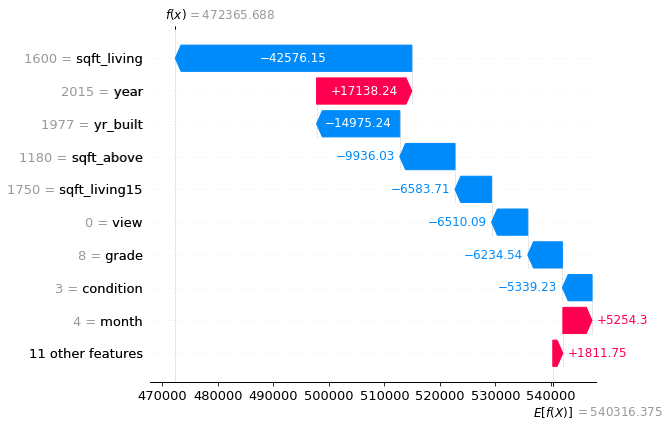

In [8]:
import shap
explainer = shap.Explainer(tree_regressor)
shap_values_1 = explainer(observations)
shap.plots.waterfall(shap_values_1[0])

Dla tej predykcji najważniejsza była powierzchnia mieszkania. Jest ona znacznie mniejsza niż średnia w całym zbiorze, więc mocno obniża ona wartość nieruchomości względem średniej.

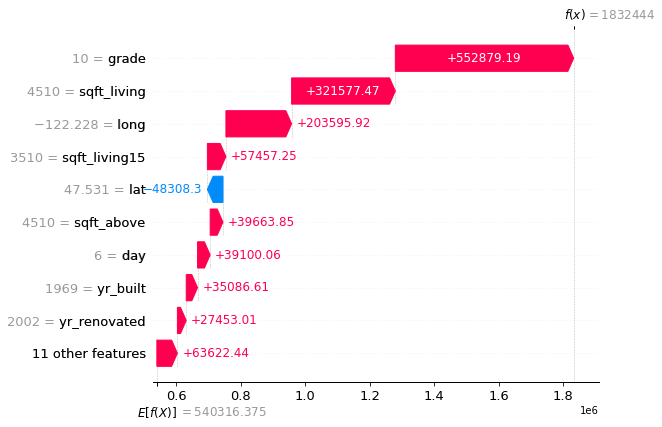

In [9]:
shap.plots.waterfall(shap_values_1[1])

Dla tej predykcji grade ma wysoką wartość (wyższą niż średnia) i ten parametr ma największy wpływ na predykcję. Podobnie dla obserwacji poniżej.

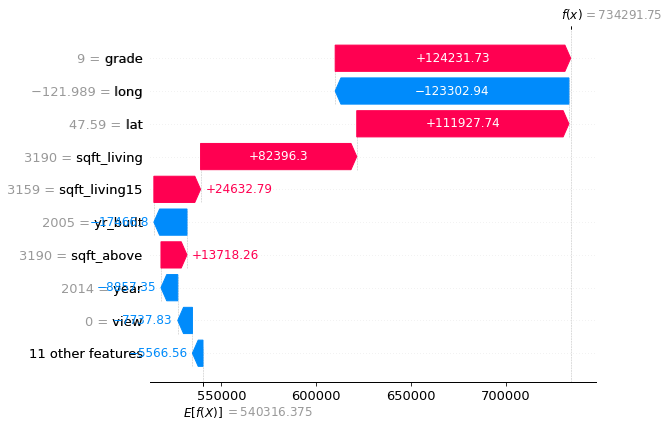

In [10]:
shap.plots.waterfall(shap_values_1[2])

# 4. Znalezienie obserwacji z innymi najważniejszymi parametrami

Poniżej dwa przykłady, dla których trzy najważniejsze parametry są inne. W pierwszym wypadku najważniejsze są metraż (sqft_living), rok sprzedaży (year) oraz rok budowy (yr_built), a w drugim jakość wykonania (grade), długość geograficzna (long) oraz szerokość geograficzna (lat).

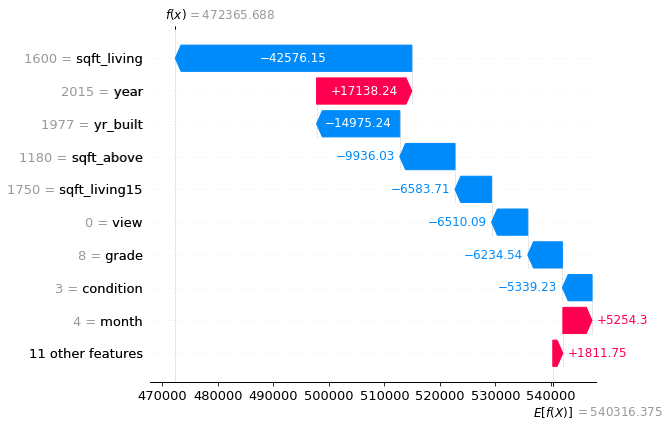

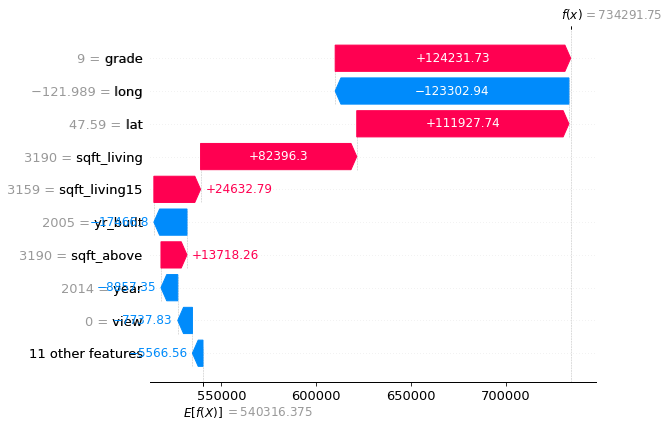

In [11]:
shap.plots.waterfall(shap_values_1[0])
shap.plots.waterfall(shap_values_1[2])

**Wyjaśnienie, dlaczego powyższe obserwacje mają inne najważniejsze parametry**

1. W pierwszym wypadku powierzchnia mieszkania jest o wiele mniejsza niż średnia dla wszystkich nieruchomości, więc znacząco obniża to cenę mieszkania. Grade jest bliski średniej (chociaż trochę większy), dlatego nieznacznie zwiększa cenę nieruchomości. Rok sprzedaży podnosi cenę mieszkania. Dzieję się tak dlatego, że ceny mieszkań rosną, więc mieszkania sprzedane w 2015 będą raczej droższe niż te z 2014.

2. W tym wypadku powierzchnia mieszkania w znacznym stopniu zwiększa jego cenę, ale wygląda na to, że dla dużych mieszkań większe znaczenie ma jego jakość wykończenia (grade), a także jego położenie (sprawdzając te współrzędne można się przekonać, że to mieszkanie jest w Seattle, aczkolwiek wszystkie dane dotyczą Seattle lub okolic). Aczkolwiek ciężko je konkretnie zinterpretować. Zwłaszcza to, że długość geograficzna zwiększa cenę, a szerokość zmniejsza.

# 5. Obserwacje, gdzie ta sama zmienna o tej samej wartości ma raz wpływ dodatni, a raz ujemny.

In [12]:
shap_values = explainer(train_x)

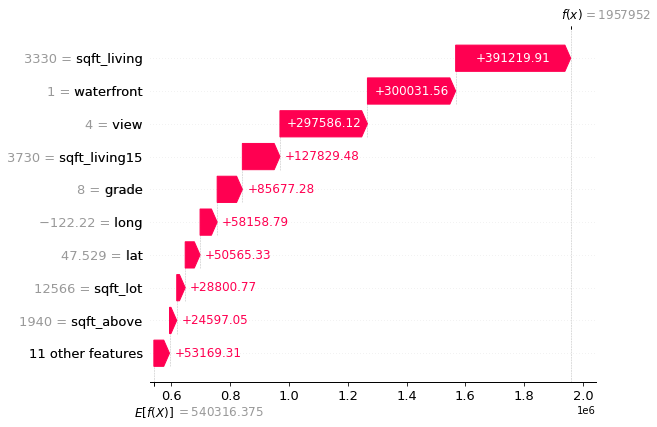

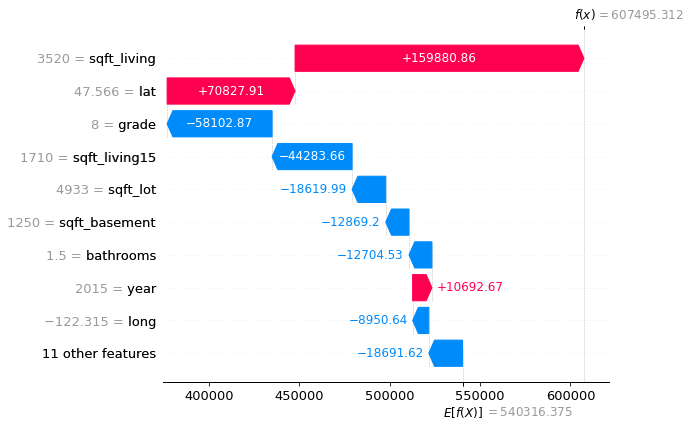

In [13]:
# Znalezienie przykładów, gdzie parametr nr 8 (czyli grade) o wartości 8 ma raz wpływ dodatni, a raz ujemny
param_id = 8
param_val = 8
mask = shap_values.data[:, param_id]==param_val
subset_idx_min = np.argmin(shap_values.values[mask, param_id])
subset_idx_max = np.argmax(shap_values.values[mask, param_id])
id_max = np.arange(shap_values.values.shape[0])[mask][subset_idx_max]
id_min = np.arange(shap_values.values.shape[0])[mask][subset_idx_min]
shap.plots.waterfall(shap_values[id_max])
shap.plots.waterfall(shap_values[id_min])

W powyższych dwóch przykładach parametr grade=8 raz ma wpływ dodatni, a raz ujemny. Poniżej wszystkie parametry tych dwóch obserwacji.

In [14]:
train_x.loc[[id_max, id_min]]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day
5067,3.0,1.75,3330.0,12566.0,1.0,1.0,4.0,4.0,8.0,1940.0,1390.0,1960.0,0.0,47.5287,-122.220,3730.0,16560.0,2015.0,2.0,13.0
7555,4.0,1.50,3520.0,4933.0,1.5,0.0,0.0,4.0,8.0,2270.0,1250.0,1929.0,0.0,47.5655,-122.315,1710.0,5400.0,2015.0,3.0,11.0


**Wyjaśnienie, dlaczego ten sam parametr (o tej samej wartości) ma różny wpływ:**

Robocza hipoteza jest taka, że parametr grade jest skorelowany z powieszchnią mieszkania. To znaczy, większe mieszkania zazwyczaj mają go wyższy, a mniejsze niższy. Więc skoro mieszkanie nr 1 ma mniejszą powieszchnię, to grade=8 może zwiększać jego cenę (bo średnia ocena, dla mieszkań tej wielkości jest na przykład mniejsza niż 8). A dla mieszkania nr 2 (o większej powierzchni) grade=8 jest poniżej standardu dla tej wielkości. Żeby sprawdzić tę hipotezę wykonano wykres (i regresję liniową) grade w zależności od sqft_living i grade w zależności od sqft_above (czyli powierzchni ponad poziomem gruntu).

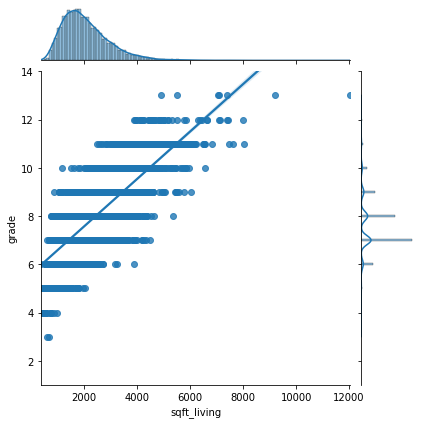

In [15]:
import seaborn as sns

graph = sns.jointplot(x='sqft_living', y='grade', data=train_x, kind='reg')
axes = graph.fig.get_axes()
lim = axes[0].set_ylim(1, 14)

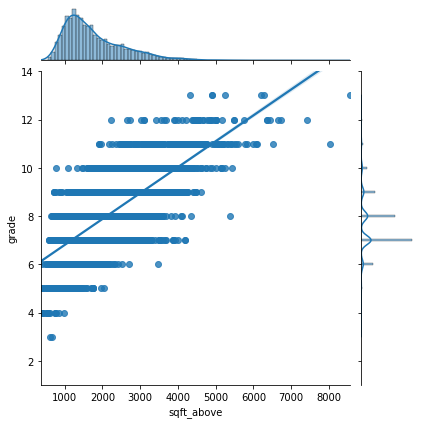

In [16]:
graph = sns.jointplot(x='sqft_above', y='grade', data=train_x, kind='reg')
axes = graph.fig.get_axes()
lim = axes[0].set_ylim(1, 14)

Na obydwu wykresach widać, że statystycznie grade rośnie wraz z powierzchnią mieszkania. Postanowiono policzyć również średnią ocenę, dla mieszkań o powierzchni pierwszego i drugiego mieszkania (dokładnie to dla mieszkań o powierzchni nie różniącej się więcej niż 100 stóp kwadratowych).

In [27]:
mean_grade_living_3330 = train_x.loc[np.abs(train_x['sqft_living']-3330.0) < 100].mean()['grade']
mean_grade_living_3520 = train_x.loc[np.abs(train_x['sqft_living']-3520.0) < 100].mean()['grade']
mean_grade_above_1940 = train_x.loc[np.abs(train_x['sqft_above']-1940.0) < 100].mean()['grade']
mean_grade_above_2270 = train_x.loc[np.abs(train_x['sqft_above']-2270.0) < 100].mean()['grade']
dane = pd.DataFrame(np.array([[mean_grade_living_3330, mean_grade_above_1940], [mean_grade_living_3520, mean_grade_above_2270]]))
dane.rename({0: 'Mieszkanie nr 1 o mniejszej powierzchni', 1: 'Mieszkanie nr 2 o większej powierzchni'}, inplace=True)
dane.rename({0: 'Średni grade uwzględniający całą powierzchnię mieszkalną', 1: 'Średni grade uwzględniający powierzchnię powyżej poziomu gruntu'}, axis=1)

,Średni grade uwzględniający całą powierzchnię mieszkalną,Średni grade uwzględniający powierzchnię powyżej poziomu gruntu
Mieszkanie nr 1 o mniejszej powierzchni,8.843478,7.774240
Mieszkanie nr 2 o większej powierzchni,9.179104,8.156057


Jak widać średnia ocena dla mieszkań o powierzchni około 3330, jest większa niż 8, ale jeśli spojrzymy tylko na powierznię ponad poziomem gruntu to już widać, że to mieszkanie ma wyższy grade niż inne mieszkania o podobnej powierzchni.

Jak spojrzymy na drugie mieszkanie to ma ono grade poniżej standardu niezależnie, czy patrzeć na powierzchnię całą, czy tylko ponad poziomem gruntu.

Więc postawiona hipoteza ma znamiona sensowności.

# 6. Wytrenowanie drugiego modelu i znalezienie obserwacji różniącej się dla modeli

In [18]:
from sklearn.svm import SVR

svm_regressor = SVR(kernel='rbf', C=100000000, gamma='scale', epsilon=0.1)
svm_regressor.fit(train_x, train_y)

print('Współczynnik determinacji dla zbiory treningowego {}'.format(svm_regressor.score(train_x, train_y)))
print('Współczynnik determinacji dla zbiory walidacyjnego {}'.format(svm_regressor.score(val_x, val_y)))
print('Współczynnik determinacji dla zbiory testowego {}'.format(svm_regressor.score(test_x, test_y)))

Współczynnik determinacji dla zbiory treningowego 0.6002875095555978
Współczynnik determinacji dla zbiory walidacyjnego 0.5728939103343913
Współczynnik determinacji dla zbiory testowego 0.5868264346618778


Drugim nauczonym modelem jest maszyna wektorów wspierających. Jak widać ma ona o wiele niższy współczynnik determinacji. Ale prawdopodobnie jej predykcje mają wystarczająco sensu, żeby analizować ją metodą shap.

In [19]:
shap.initjs()
explainer = shap.KernelExplainer(svm_regressor.predict, train_x[:100])
shap_values_2 = explainer.shap_values(train_x[:2])
shap.force_plot(explainer.expected_value, shap_values_2[0], train_x.iloc[0,:])

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_2[1], train_x.iloc[1,:])

Powyżej przykłady dekompozycji dla dwóch obserwacji (tych samych dwóch co dla pierwszego modelu). Istnieją pewne podobieństwa, ale jest też sporo różnic. Poniżej dwa wykresy dla tych samych obserwacji ale pierwszego modelu.

In [21]:
shap.initjs()
shap.plots.force(shap_values_1[0])

In [22]:
shap.initjs()
shap.plots.force(shap_values_1[1])

**Wyjaśnienie**:

SVM uwzględnia przede wszystkim powierzchnie mieszkalną (pierwszy model też ją uwzględnie, ale nie zawsze ma duży wpływ). Pierwszy model za to często uwzględnia grade, czego nie robi drugi model. Można to próbować uzasadnić w ten sposób, że po pierwsze drugi model gorzej się nauczył, więc nie "wie", które cechy są ważne oraz w taki sposób, że różne modele uczą się różnych aspektów.

Aczkolwiek najprawdopodobniej dzieje się tak dlatego, że SVM powinien mieć znormalizowane dane (jako, że nie są to uczy się przede wszystkim tych które mają duże wartośc). Postanowiono dlatego nauczyć SVMa danymi znormalizowanymi.

In [23]:
train_x_norm, train_y_norm = (train_x-train_x.mean())/train_x.std(), (train_y-train_y.mean())/train_y.std()
val_x_norm, val_y_norm = (val_x-val_x.mean())/val_x.std(), (val_y-val_y.mean())/val_y.std()
test_x_norm, test_y_norm = (test_x-test_x.mean())/test_x.std(), (test_y-test_y.mean())/test_y.std()

svm_regressor_norm = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.01)
svm_regressor_norm.fit(train_x_norm, train_y_norm)

print('Współczynnik determinacji dla zbiory treningowego {}'.format(svm_regressor_norm.score(train_x_norm, train_y_norm)))
print('Współczynnik determinacji dla zbiory walidacyjnego {}'.format(svm_regressor_norm.score(val_x_norm, val_y_norm)))
print('Współczynnik determinacji dla zbiory testowego {}'.format(svm_regressor_norm.score(test_x_norm, test_y_norm)))

Współczynnik determinacji dla zbiory treningowego 0.937121227711014
Współczynnik determinacji dla zbiory walidacyjnego 0.8259054680811699
Współczynnik determinacji dla zbiory testowego 0.7357296954692019


Jak widać po znormalizowaniu danych SVM uzyskał lepsze współczynniki determinacji niż ostatnio. Poniżej analiza metodą SHAP tych samych dwóch obserwacji co ostanio.

In [24]:
shap.initjs()
explainer = shap.KernelExplainer(svm_regressor_norm.predict, train_x_norm[:100])
shap_values_2_norm = explainer.shap_values(train_x_norm[:2])
shap.force_plot(explainer.expected_value, shap_values_2_norm[0], train_x_norm.iloc[0,:])

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_2_norm[1], train_x_norm.iloc[1,:])

Powyżej wykres dla obserwacji nr 2 i modelu SVM znormalizowanego, a poniżej wykres dla obserwacji nr 2 i modelu drzewiastego.

In [26]:
shap.initjs()
shap.plots.force(shap_values_1[1])

Tym razem wykresy te wyglądają podobnie na pierwszy rzut oka. Aczkolwiek na górnym najważniejszą cechą jest powierzchnia mieszkań najbliższych 15 sąsiadów. Na drugim miejscu jest grade. Na dolnym najważniejszą cechą jest grade.